<a href="https://colab.research.google.com/github/nischay-32/Vision-Transfromer/blob/main/ViT_classifier_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install keras
!pip install matplotlib

In [2]:
#import libraries
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import warnings
# Ignore warnings
warnings.filterwarnings("ignore")

In [3]:
num_classes = 10
input_shape = (32,32,3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [16]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 40
image_size = 72  #well resize input images to this size
patch_size = 6 #size of the patches to be extracted from input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim*2,
    projection_dim
] #size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024] #size of the dense layers of the final classifier


In [17]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomZoom(
            height_factor = 0.2, width_factor = 0.2)
    ],
    name="data_augmentation"
)
data_augmentation.layers[0].adapt(x_train)


In [18]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x


In [19]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()   # Correct way
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1,1,1,1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches,[batch_size, -1, patch_dims])
        return patches

Image size: 72 x 72
Patch size: 6 x 6
Patches per image: 144
Elements per patch: 108


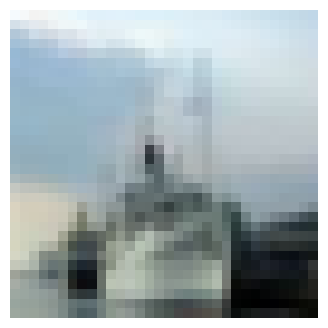

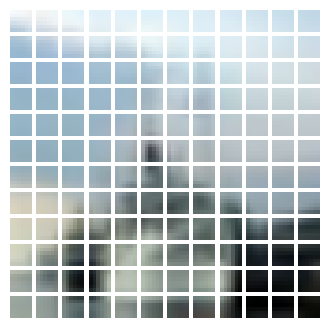

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} x {image_size}")
print(f"Patch size: {patch_size} x {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4,4))
for i,patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i+1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")


In [21]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded


In [22]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data

    # MODIFIED: Changed the variable name from 'augment' to 'augmented' for consistency
    augmented = data_augmentation(inputs)

    # create patches
    # NOW THIS LINE WORKS CORRECTLY:
    patches = Patches(patch_size)(augmented)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # create multiple layers of the transformer block
    for _ in range(transformer_layers):
        #layers normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # create a multi-head attension layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1,x1)
        # skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])
        # layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        #MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # skip connection2
        encoded_patches = layers.Add()([x3, x2])

    #create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    #classify outputs
    logits = layers.Dense(num_classes)(features)
    # create keras Model
    model = keras.Model(inputs=inputs, outputs=logits) # FIXED: Typo 'inouts' -> 'inputs'
    return model


In [33]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(name="top_5_accuracy"),
        ],
    )

    checkpoint_filepath = "./tmp/checkpoint.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy* 100,2)}%")
    print(f"Test Top 5 accuracy: {round(top_5_accuracy*100, 2)}%")


In [34]:
vit_classifier = create_vit_classifier()
history = run_experiment(vit_classifier)

Epoch 1/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 100s 397ms/step - accuracy: 0.2177 - loss: 2.7105 - top_5_accuracy: 0.7124 - val_accuracy: 0.4006 - val_loss: 1.6755 - val_top_5_accuracy: 0.8818
Epoch 2/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 80s 411ms/step - accuracy: 0.3572 - loss: 1.7910 - top_5_accuracy: 0.8477 - val_accuracy: 0.4662 - val_loss: 1.4853 - val_top_5_accuracy: 0.9086
Epoch 3/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 82s 413ms/step - accuracy: 0.4106 - loss: 1.6372 - top_5_accuracy: 0.8837 - val_accuracy: 0.4930 - val_loss: 1.3910 - val_top_5_accuracy: 0.9312
Epoch 4/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 78s 388ms/step - accuracy: 0.4499 - loss: 1.5332 - top_5_accuracy: 0.9024 - val_accuracy: 0.5418 - val_loss: 1.2889 - val_top_5_accuracy: 0.9432
Epoch 5/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 86s 412ms/step - accuracy: 0.4682 - loss: 1.4793 - top_5_accuracy: 0.9100 - val_accuracy: 0.5586 - val_loss: 1.2292 - val_top_5_accuracy: 0.9548
Epoch 6/40
176/176 ━━━━━━━━━━━━━━━━━━━━ 74s 419ms/step - accuracy: 0.4888 

In [39]:
class_names = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [40]:
def img_predict(image, model):
    # Add a batch dimension because the model expects it: (32, 32, 3) -> (1, 32, 32, 3)
    image_batch = np.expand_dims(image, axis=0)

    # Get model predictions
    out = model.predict(image_batch)

    # Get the index of the highest probability
    prediction_index = np.argmax(out, axis=1)

    # Look up the class name using the index
    predicted_class = class_names[prediction_index[0]]

    return predicted_class

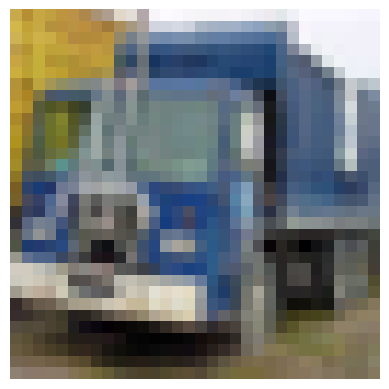

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
The image is classified as: truck


In [41]:
# --- Example Usage ---
# Pick an image from the test set
index = 14
plt.imshow(x_test[index])
plt.axis("off")
plt.show()

# Get the prediction
prediction = img_predict(x_test[index], vit_classifier)
print(f"The image is classified as: {prediction}")